In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import os
import scipy.stats as st
import json
import lib.galaxy_utilities as gu
import lib.python_model_renderer.parse_annotation as pa

In [3]:
# %run make_bulge_bar_dataframes.py

In [4]:
bulge_df = pd.read_pickle('bulge_fractions.pkl').dropna()
bar_df = pd.read_pickle('bar_fractions.pkl').dropna()
bar_length_df = pd.read_pickle('bar_lengths.pkl')
display(bulge_df.head(3))
display(bar_df.head(3))
display(bar_length_df.dropna().head(3))

,GZB fraction,GZ2 bulge dominated,GZ2 no bulge
subject_id,,,
20902000,0.709677,False,0.068850
20902007,0.806452,False,0.062377
20902023,0.774194,False,0.000000


,GZB fraction,GZ2 bar fraction,Strongly barred,No bar
subject_id,,,,
20902000,0.354839,0.736751,True,False
20902007,0.322581,0.072191,False,True
20902023,0.096774,0.022762,False,True


,GZB bar length,GZ2 bar fraction,GZB fraction
subject_id,,,
20902008,16.999998,0.834784,0.516129
20902040,18.134869,0.747899,0.531250
20902053,20.588576,0.873468,0.709677


In [5]:
len(bulge_df), len(bar_df), len(bar_length_df)

(288, 288, 295)

## How frequently do people draw bulges relative to GZ2 pBulge?

In [6]:
gzb_bulge_mean = bulge_df['GZB fraction'].mean()
gzb_bulge_std = bulge_df['GZB fraction'].std()
print('\nGZB bulge fraction = {:.4f} ± {:.5f}\n'.format(
    gzb_bulge_mean, gzb_bulge_std
))
bulge_groups = bulge_df.groupby('GZ2 bulge dominated')
display(pd.DataFrame(
    np.hstack((bulge_groups.mean(), bulge_groups.std()))[:, :2],
    columns=('mean', 'std'),
#     index=bulge_groups.mean().index
))

ttest_result = st.ttest_ind(
    bulge_df[bulge_df['GZ2 bulge dominated']]['GZB fraction'].values,
    bulge_df[~bulge_df['GZ2 bulge dominated']]['GZB fraction'].values
)
print('Probability samples are the same: {:%}'.format(ttest_result.pvalue))


GZB bulge fraction = 0.7520 ± 0.07967



,mean,std
0,0.751365,0.143952
1,0.755107,0.021487


Probability samples are the same: 76.698805%


Is there a negative correlation between the number of people flagging the galaxy as bulgeless, and the number of people using a bulge in their model?

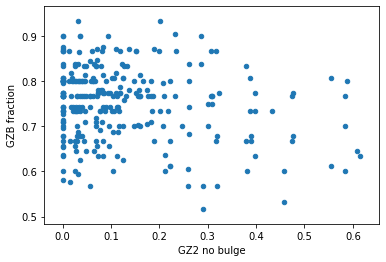

In [7]:
bulge_df.plot('GZ2 no bulge', 'GZB fraction', kind='scatter')

## How frequently do people draw bars relative to GZ2 pBar?

In [8]:
bar_df['type'] = pd.cut(bar_df['GZ2 bar fraction'], (-1, 0.2, 0.5, 2), labels=('No bar', 'Weak bar', 'Strong bar'))
bar_df.groupby('type')['GZB fraction'].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
No bar,136.0,0.295095,0.105353,0.096774,0.231452,0.285786,0.354839,0.633333
Weak bar,91.0,0.385346,0.120350,0.129032,0.300000,0.387097,0.466667,0.677419
Strong bar,61.0,0.472846,0.142678,0.151515,0.375000,0.466667,0.566667,0.733333


In [9]:
print('GZB bar fraction = {:.4f} ± {:.5f}\n'.format(
    bar_df['GZB fraction'].mean(),
    bar_df['GZB fraction'].std()
))

print('P(model has bar | Strongly barred) = {:.4f} ± {:.4f}%'.format(
    bar_df.groupby('Strongly barred')['GZB fraction'].mean().loc[True],
    bar_df.groupby('Strongly barred')['GZB fraction'].std().loc[True],
))

print('P(model has bar | No bar)          = {:.4f} ± {:.4f}%'.format(
    bar_df.groupby('No bar')['GZB fraction'].mean().loc[True],
    bar_df.groupby('No bar')['GZB fraction'].std().loc[True],
))

ttest_result = ttest_ind(
    bar_df[bar_df['Strongly barred']]['GZB fraction'].values,
    bar_df[bar_df['No bar']]['GZB fraction'].values
)
print('\nProbability samples are the same: {:%}'.format(ttest_result.pvalue))

GZB bar fraction = 0.3613 ± 0.13756

P(model has bar | Strongly barred) = 0.4728 ± 0.1427%
P(model has bar | No bar)          = 0.2951 ± 0.1054%


NameError: name 'ttest_ind' is not defined

In [10]:
bulge_df.sample(5)

,GZB fraction,GZ2 bulge dominated,GZ2 no bulge
subject_id,,,
21096912,0.800000,False,0.165479
21686535,0.566667,False,0.291107
20901992,0.656250,False,0.025016
20902053,0.741935,True,0.018201
21096850,0.838710,False,0.123053


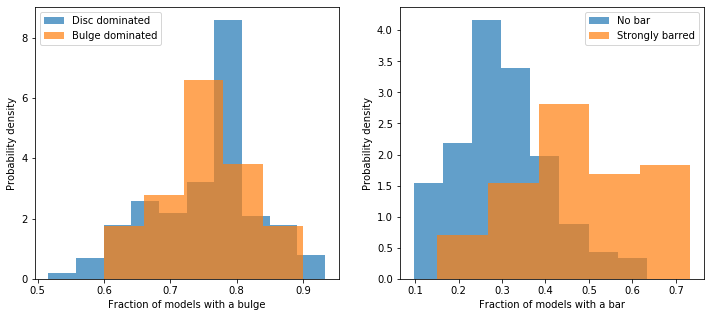

In [11]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
res = bulge_df.groupby('GZ2 bulge dominated')
plt.hist(bulge_df.loc[res.groups[False]]['GZB fraction'], bins='scott',
         alpha=0.7, label='Disc dominated', density=True)
plt.hist(bulge_df.loc[res.groups[True]]['GZB fraction'], bins='scott',
         alpha=0.7, label='Bulge dominated', density=True)
plt.title('')
plt.legend()
plt.xlabel('Fraction of models with a bulge')
plt.ylabel('Probability density');
plt.subplot(122)
plt.hist(bar_df[bar_df['No bar']]['GZB fraction'], bins='scott',
         alpha=0.7, label='No bar', density=True)
plt.hist(bar_df[bar_df['Strongly barred']]['GZB fraction'], bins='scott',
         alpha=0.7, label='Strongly barred', density=True)
plt.title('')
plt.legend()
plt.xlabel('Fraction of models with a bar')
plt.ylabel('Probability density');
plt.savefig('method-paper-plots/bulge-bar-population-comparison.pdf',
            bbox_inches='tight')

## How does pbar stack up against aggregate bar length?

Spearman correlation:


,GZB bar length,GZ2 bar fraction,GZB fraction
GZB bar length,1.000000,0.112497,0.054490
GZ2 bar fraction,0.112497,1.000000,0.569798
GZB fraction,0.054490,0.569798,1.000000


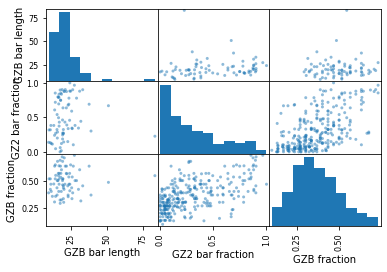

In [12]:
# bar_length_df.plot.scatter(x='GZ2 bar fraction', y='GZB bar length')
print('Spearman correlation:')
display(bar_length_df.corr('pearson'))
pd.plotting.scatter_matrix(bar_length_df);

In [13]:
bar_length_df[bar_length_df['GZB bar length'] > 50]

,GZB bar length,GZ2 bar fraction,GZB fraction
subject_id,,,
21096944,51.000000,0.668341,0.483871
21096787,82.999984,0.226558,0.545455


In [14]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor()
mask = clf.fit_predict(
    np.expand_dims(bar_length_df['GZB bar length'].dropna(), 1)
) > 0
bad_indices = bar_length_df['GZB bar length'].dropna()[~mask].index

/Users/tlingard/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


In [15]:
bar_length_df_cleaned = bar_length_df.copy()
bar_length_df_cleaned['GZB bar length'].loc[bad_indices] = np.nan

,GZB bar length,GZ2 bar fraction,GZB fraction
GZB bar length,1.000000,0.242748,0.020185
GZ2 bar fraction,0.242748,1.000000,0.569798
GZB fraction,0.020185,0.569798,1.000000


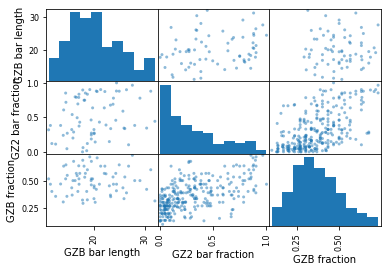

In [16]:
display(bar_length_df_cleaned.corr('pearson'))
pd.plotting.scatter_matrix(bar_length_df_cleaned);

In [17]:
def get_agg_bulge_reff(subject_id):
    diff_data = gu.get_image_data(subject_id)
    size_diff = diff_data['width'] / diff_data['imageWidth']
    model_file = 'cluster-output/{}.json'.format(subject_id)
    try:
        with open(model_file) as f:
            model = json.load(f)
    except IOError:
        return np.nan
    bulge = pa.parse_aggregate_model(model, size_diff)['bulge']
    disk = pa.parse_aggregate_model(model, size_diff)['disk']
    if bulge is None or disk is None:
        return np.nan
    return bulge.get('rEff', np.nan) / disk.get('rEff', np.nan)

In [18]:
bulge_df['GZB bulge size'] = pd.Series(bulge_df.index, index=bulge_df.index).apply(get_agg_bulge_reff)

Disc dominated (3.839652037073204, 0.051289325399937996, 0.027384979072298102)
Bulge dominated (2.6205253730008233, 0.07953463280766156, 0.043315943899042614)


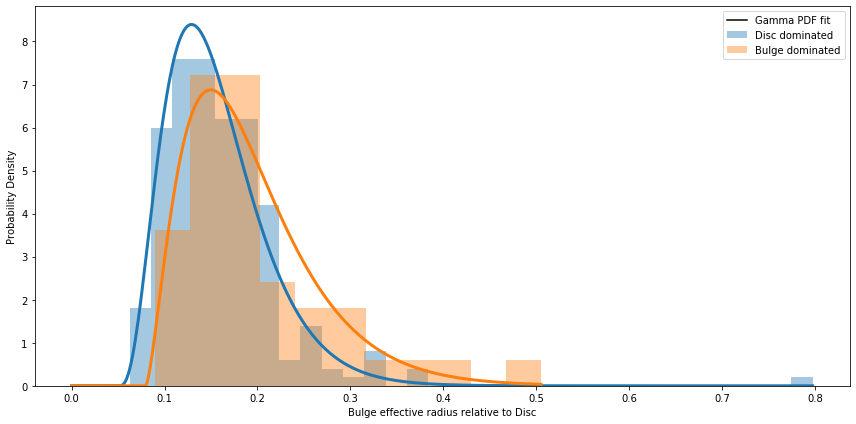

In [35]:
plt.figure(figsize=(12, 6))
for i, flag in enumerate((False, True)):
    mask = bulge_df['GZ2 bulge dominated'] == flag
    label = 'Bulge dominated' if flag else 'Disc dominated'
    data = bulge_df[mask]['GZB bulge size'].dropna()
    outlier_mask = np.abs(st.stats.zscore(data)) < 3
    counts, bins, patches = plt.hist(data, density=True, bins='auto', alpha=0.4, label=label, color='C{}'.format(i%10))
    params = st.gamma.fit(data[outlier_mask])
    x = np.linspace(0, np.max(bins), 500)
    rv = st.gamma(params[0], loc=params[1], scale=params[2])
    plt.plot(x, rv.pdf(x), c='C{}'.format(i%10), lw=3)
    print(label, params)
plt.plot([], [], 'k-', label='Gamma PDF fit')
plt.ylabel('Probability Density')
plt.xlabel('Bulge effective radius relative to Disc')
plt.legend()
plt.tight_layout()
plt.savefig('method-paper-plots/aggregate_bulge_size_comparison.pdf', bbox_inches='tight');